In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm import tqdm
import pathlib


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision.transforms as T

#sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io

################# DETR FUCNTIONS FOR LOSS #######################
import sys
sys.path.append('./detr_custom/')

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

from typing import Iterable, Sequence, List, Tuple, Dict, Optional, Union, Any
from types import ModuleType
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from generators import BlenderStandardDataset, TorchStandardDataset
import importlib
from pprint import pprint
import sqlite3 as db

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
def pytorch_init_janus_gpu():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Unexpected GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)


def reloader(module_or_member: Union[ModuleType, Any]):    
    if isinstance(module_or_member, ModuleType):
        importlib.reload(module_or_member)
        return module
    else:
        module = importlib.import_module(module_or_member.__module__)
        importlib.reload(module)
        return module.__dict__[module_or_member.__name__]

In [3]:
seed = 42069
seed_everything(seed)

try:
    device = pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [4]:
TORCH_CACHE_DIR = 'torch_cache'
DATASET_DIR = '/mnt/blendervol/objdet_std_data'
SQL_TABLE = 'bboxes_std'
WEIGHTS_DIR = 'fish_statedicts'
BATCH_SIZE = 1
LR = 1e-5
NUM_CLASSES=6+1
NULL_CLASS_COEF=0.5

In [5]:
db_con = db.connect(f'file:{os.path.join(DATASET_DIR,"bboxes.db")}?mode=ro', uri=True)

In [6]:
n_data = pd.read_sql_query('SELECT COUNT(DISTINCT(imgnr)) FROM bboxes_std', db_con).values[0][0]

TRAIN_RANGE = (0, int(3/4*n_data))
VAL_RANGE = (int(3/4*n_data), n_data)

In [7]:
torch.hub.set_dir(TORCH_CACHE_DIR)

In [8]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load(
            os.path.join(TORCH_CACHE_DIR, 'facebookresearch_detr_master'), 
            model='detr_resnet50', 
            pretrained=True,
            source='local'
        )
        
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

model = DETRModel(NUM_CLASSES, 100)
model = model.to(device)

In [9]:
def save_model(obj: Any, f: str):
    # Create dir
#     if path_f.parent != '.':
    pathlib.Path(f).parent.mkdir(parents=True, exist_ok=True)
    assert isinstance(f, str), "Filename must be of type string when saving model"
    torch.save(obj=obj, f=f)
    

def train_model(
        trainloader: DataLoader, 
        valloader: DataLoader, 
        model: nn.Module, 
        criterion, 
        optimizer, 
        n_epochs: int, 
        device: torch.device, 
        save_best: bool = True
    ):
    
    best_val_loss = np.inf
    
    for epoch in range(n_epochs):

        running_train_loss = 0.0

        trainbar = tqdm(
            iterable=enumerate(trainloader, 0),
            total=len(trainloader),
            unit=' batches',
            desc=f' Epoch {epoch+1}/{n_epochs}',
            ascii=True,
            position=0,
            leave=False
        )

        model.train()
        criterion.train()
        
        # Loop through train batches
        for i, (images, labels) in trainbar:
            images = [image.to(device) for image in images]
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

            output = model(images)
        
            loss_dict = criterion(output, labels)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
            # Zero parameter gradients since PyTorch will just accumulate the gradient
            # vectors while it trains (in order to get the "mean" direction to move in
            # the parameter space). Also doing it this way minimizes memory allocation
            # etc, probably.
            optimizer.zero_grad()
    
            losses.backward() # Computes gradients
            optimizer.step() # Do a gradient step
    
            # print statistics
            running_train_loss += losses.item()
            train_loss = running_train_loss / (i+1)
            traintqdminfo = {'train loss':train_loss}
            trainbar.set_postfix(traintqdminfo)
         
        running_val_loss = 0.0
        
        # valbar will disappear after it is done since leave=False
        valbar = tqdm(
            iterable=enumerate(valloader, 0), 
            total=len(valloader), 
            unit=' batches',
            desc=f' Validating',
            ascii=True,
            position=0,
            leave=False
        )
        
        model.eval()
        criterion.eval()
        
        # Loop through val batches
        with torch.no_grad():
            for i, (images, labels) in valbar:
                images = [image.to(device) for image in images]
                labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

                output = model(images)

                loss_dict = criterion(output, labels)
                weight_dict = criterion.weight_dict
                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                # print statistics
                running_val_loss += losses.item()
                val_loss = running_val_loss / (i+1)
                valtqdminfo = {**traintqdminfo, 'val loss':val_loss}
                valbar.set_postfix(valtqdminfo)
        
        # Extra dirty tqdm hack hehe
        trainbar.disable = False
        trainbar.set_postfix({**traintqdminfo, **valtqdminfo})
        trainbar.disable = True
        print(file=sys.stderr)
        
        # Save best models
        if save_best:
            if valtqdminfo['val loss'] < best_val_loss:
                isodatenow = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
                daydir = datetime.today().strftime("weights_%Y-%m-%d")
                filename = (
                    f'detr_statedicts_epoch{epoch+1}'
                    f'_train{train_loss:.4f}_val{val_loss:.4f}'
                    f'_{isodatenow}.pth'
                )
                filepath = os.path.join(WEIGHTS_DIR, daydir, filename)

                save_model(
                    obj={
                        'optimizer':optimizer.state_dict(),
                        'model':model.state_dict(),
                        'criterion':criterion.state_dict(),
                    },
                    f = filepath
                )
        
            

In [19]:
weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']
matcher = HungarianMatcher()
criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

traingen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False, imgnrs=range(0,32))
valgen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False, imgnrs=range(32,48))

trainloader = DataLoader(
    dataset=traingen,
    batch_size=8,
    collate_fn=lambda x: tuple(zip(*x)),
)

valloader = DataLoader(
    dataset=valgen,
    batch_size=8,
    collate_fn=lambda x: tuple(zip(*x)),
)

train_model(
    trainloader,
    valloader,
    model,
    criterion,
    optimizer,
    n_epochs=8,
    device=device,
    save_best=False
)

 Epoch 8/8: 100%|##########| 4/4 [00:01<00:00,  4.12 batches/s, train loss=1.23, val loss=1.33] 


tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6], device='cuda:1')


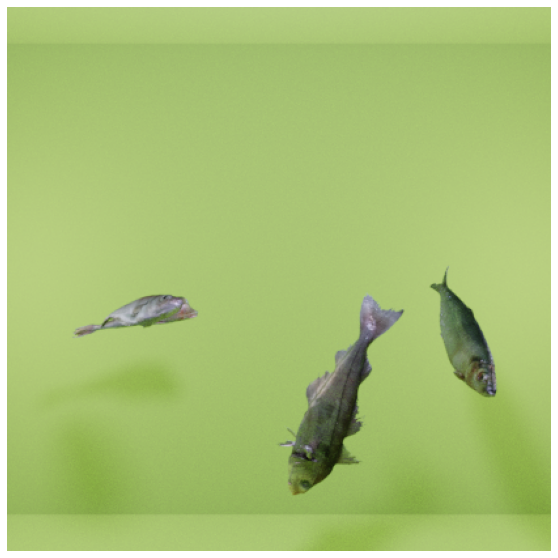

In [21]:
def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def plot_results(img: Image.Image, classes: Iterable, boxes: Iterable):
    fig, ax = plt.subplots(figsize=(16,10))
    plt.imshow(img)
    
    if len(boxes) != 0:
        h, w = img.shape[:2]
        boxes = box_cxcywh_to_xyxy(boxes)
        boxes[:,[0,2]] *= w
        boxes[:,[1,3]] *= h

        for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='cyan', linewidth=3))
            try:
                ax.text(xmin, ymin, CLASSES[cls], fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
            except:
                pass
            
    plt.axis('off')
    plt.show()

    
def postprocess(logits: torch.Tensor, boxes: torch.Tensor):
    keepmask = logits.softmax(-1)[:,:-1].max(-1)[0] > 0.7
    if any(keepmask) == False:
        return torch.Tensor(), torch.Tensor()
    return logits[keepmask].argmax(-1), boxes[keepmask]


    
def eval_model(model, image):
    with torch.no_grad():
        model.eval()
        
        output = model([image.to(device)])
        
        boxes = output['pred_boxes'][0]
        logits = output['pred_logits'][0]
        print(logits.argmax(-1))
        
        logits_, boxes_ = postprocess(logits, boxes)
        
        plot_results(image.numpy().transpose((1,2,0)), logits_, boxes_)
    
x, y = traingen[0]
eval_model(model, x)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [ ]:
raise ValueError

In [ ]:
import time

boii = tqdm(range(10), leave=False)

for i in boii:
    time.sleep(0.05)

boii.disable = False
boii.set_postfix({'BABA':'yeye'})
# boii.refresh()

In [ ]:
3000//2

In [ ]:
batch_size = 2
batchnr = 4999
n = 10000
print(n//batch_size)
np.arange(n)[batch_size*batchnr:batch_size*(batchnr+1)]

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_fn(dataloader, model, criterion, optimizer, device, scheduler):
    model.train()
    criterion.train()
    
    mean = np.array([0.64817397, 0.75178422, 0.43881263])
    std = np.array([0.06833826, 0.07720845, 0.05868721])
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(dataloader, total=len(dataloader)-1)
    
    for step, (images, targets) in enumerate(tk0):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss


def eval_fn(dataloader, model, criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        tk0 = tqdm(dataloader, total=len(dataloader)-1)
        for step, (images, targets) in enumerate(tk0):
            
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss